# Recreation of accepted solution from Challenge on LINE 1003.02

In [1]:
import torch
import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import random
from tabulate import tabulate

import magnav

In [2]:
print(f'PyTorch version : {torch.__version__}, Version used for dev : 1.9.0+cu102')

PyTorch version : 1.9.0+cu102, Version used for dev : 1.9.0+cu102


In [3]:
torch.manual_seed(27) # For reproducibility
random.seed(27)
np.random.seed(27)
torch.cuda.manual_seed(27)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# 0 - Load Solution Dataset

In [4]:
df = pd.read_hdf('../data/interim/Sol_dataset.h5', key=f'Flt1003')

In [5]:
df.head()

,FLUXB_TOT,FLUXB_X,FLUXC_TOT,FLUXC_Y,FLUXD_Y,FLUXD_Z,TL_comp_mag3_sq,UNCOMPMAG3,TL_comp_mag4_sq,TL_comp_mag5_sq,V_CABT,LINE,IGRFMAG1
Time [s],,,,,,,,,,,,,
49820.0,52836.179,40991.107,56629.409,-24121.629,-22136.973,10486.244,-766.434322,53000.806,-1663.716770,18.101326,26.210,1003.01,-183.066
49820.1,52834.254,40995.387,56629.059,-24107.552,-22123.009,10491.522,-756.698780,53011.817,-1664.800715,18.577786,26.169,1003.01,-183.522
49820.2,52832.980,41000.448,56627.953,-24095.028,-22109.401,10497.816,-752.838930,53016.958,-1665.502872,20.299362,26.022,1003.01,-183.957
49820.3,52832.305,41006.539,56626.660,-24084.577,-22097.326,10505.743,-754.855151,53016.190,-1666.318939,22.430078,25.839,1003.01,-184.368
49820.4,52832.223,41013.213,56625.663,-24076.470,-22088.167,10515.313,-761.346898,53010.724,-1667.153810,23.923401,25.731,1003.01,-184.759


In [6]:
df_100302 = df.loc[df.LINE==1003.02].drop(columns='LINE').copy()
df_100308 = df.loc[df.LINE==1003.08].drop(columns='LINE').copy()
df_100304 = df.loc[df.LINE==1003.04].drop(columns='LINE').copy()

df_100302

,FLUXB_TOT,FLUXB_X,FLUXC_TOT,FLUXC_Y,FLUXD_Y,FLUXD_Z,TL_comp_mag3_sq,UNCOMPMAG3,TL_comp_mag4_sq,TL_comp_mag5_sq,V_CABT,IGRFMAG1
Time [s],,,,,,,,,,,,
50713.0,52809.731,45836.527,57309.322,-20373.009,-17985.210,16380.877,-941.209664,53523.946,-1904.899320,79.190021,25.764,-87.226
50713.1,52811.018,45820.851,57306.630,-20424.408,-18037.225,16357.652,-938.797342,53523.221,-1903.332447,79.387825,25.848,-86.141
50713.2,52812.682,45813.903,57305.748,-20462.687,-18075.506,16349.904,-935.928254,53523.888,-1901.457016,80.575036,25.972,-85.007
50713.3,52814.429,45811.527,57306.206,-20490.384,-18102.921,16349.999,-933.146768,53525.144,-1899.578546,81.798915,26.139,-83.824
50713.4,52816.019,45809.846,57307.524,-20510.464,-18122.788,16350.580,-930.723734,53526.096,-1898.021817,83.025640,26.333,-82.591
...,...,...,...,...,...,...,...,...,...,...,...,...
54496.6,51280.093,28121.512,54972.514,12335.581,14158.832,-4215.732,-1542.686492,51709.089,-2606.486269,-336.052272,25.953,-438.465
54496.7,51273.877,28018.915,54956.556,12293.129,14111.604,-4362.922,-1543.269818,51698.779,-2607.646401,-337.046554,25.810,-439.180
54496.8,51267.495,27921.771,54942.245,12243.237,14057.119,-4507.320,-1544.368424,51688.472,-2609.735169,-338.136374,25.665,-439.882


# 1 - Preprocessing

## 1.1 - Low pass filter

This filter comes from Matlab lowpass filter (This are the coefficients extracted from Matlab)

In [7]:
num = [0.00013485,0.00014468,7.8213e-05,-0.00010382,-0.00043744,-0.00094761,-0.0016395,-0.0024902,-0.0034418,-0.0043974,
        -0.005221,-0.0057423,-0.0057668,-0.0050899,-0.003516,-0.00087932,0.0029351,0.007972,0.014191,0.021457,0.029541,0.03813,
        0.046838,0.055236,0.062881,0.069347,0.074263,0.077335,0.078381,0.077335,0.074263,0.069347,0.062881,0.055236,0.046838,
        0.03813,0.029541,0.021457,0.014191,0.007972,0.0029351,-0.00087932,-0.003516,-0.0050899,-0.0057668,-0.0057423,-0.005221,
        -0.0043974,-0.0034418,-0.0024902,-0.0016395,-0.00094761,-0.00043744,-0.00010382,7.8213e-05,0.00014468,0.00013485]
den = 1

sos = signal.tf2sos(num,den)

In [8]:
def apply_lowpass_filter(df,nb_filt=1):
    
    for n in range(nb_filt):
        df['FLUXB_TOT']  = signal.sosfiltfilt(sos,df['FLUXB_TOT'])
        df['FLUXB_X']    = signal.sosfiltfilt(sos,df['FLUXB_X'])
        df['FLUXC_TOT']  = signal.sosfiltfilt(sos,df['FLUXC_TOT'])
        df['FLUXC_Y']    = signal.sosfiltfilt(sos,df['FLUXC_Y'])
        df['FLUXD_Y']    = signal.sosfiltfilt(sos,df['FLUXD_Y'])
        df['FLUXD_Z']    = signal.sosfiltfilt(sos,df['FLUXD_Z'])
        df['UNCOMPMAG3'] = signal.sosfiltfilt(sos,df['UNCOMPMAG3'])
        df['V_CABT']     = signal.sosfiltfilt(sos,df['V_CABT'])


In [9]:
apply_lowpass_filter(df_100302,10)
apply_lowpass_filter(df_100308,10)
apply_lowpass_filter(df_100304,10)
df_100302

,FLUXB_TOT,FLUXB_X,FLUXC_TOT,FLUXC_Y,FLUXD_Y,FLUXD_Z,TL_comp_mag3_sq,UNCOMPMAG3,TL_comp_mag4_sq,TL_comp_mag5_sq,V_CABT,IGRFMAG1
Time [s],,,,,,,,,,,,
50713.0,52812.377887,45838.824381,57312.194412,-20374.030120,-17986.111440,16381.698029,-941.209664,53526.628684,-1904.899320,79.190021,25.765291,-87.226
50713.1,52812.209715,45820.234772,57310.523152,-20377.377628,-17990.577489,16345.361373,-938.797342,53524.443828,-1903.332447,79.387825,25.783319,-86.141
50713.2,52812.041407,45801.657678,57308.850509,-20380.582877,-17994.901554,16309.022223,-935.928254,53522.265896,-1901.457016,80.575036,25.801266,-85.007
50713.3,52811.872828,45783.105217,57307.175082,-20383.505365,-17998.943421,16272.677679,-933.146768,53520.101715,-1899.578546,81.798915,25.819054,-83.824
50713.4,52811.703849,45764.588734,57305.495444,-20386.008083,-18002.566390,16236.324058,-930.723734,53517.957917,-1898.021817,83.025640,25.836604,-82.591
...,...,...,...,...,...,...,...,...,...,...,...,...
54496.6,51265.495920,27846.463412,54937.374140,12182.022554,13992.842644,-4643.050357,-1542.686492,51685.356262,-2606.486269,-336.052272,25.573827,-438.465
54496.7,51263.756760,27825.088167,54933.639176,12171.475786,13981.234917,-4672.193079,-1543.269818,51682.298063,-2607.646401,-337.046554,25.564349,-439.180
54496.8,51261.979771,27802.843644,54929.794384,12160.926812,13969.590478,-4702.407181,-1544.368424,51679.159910,-2609.735169,-338.136374,25.554736,-439.882


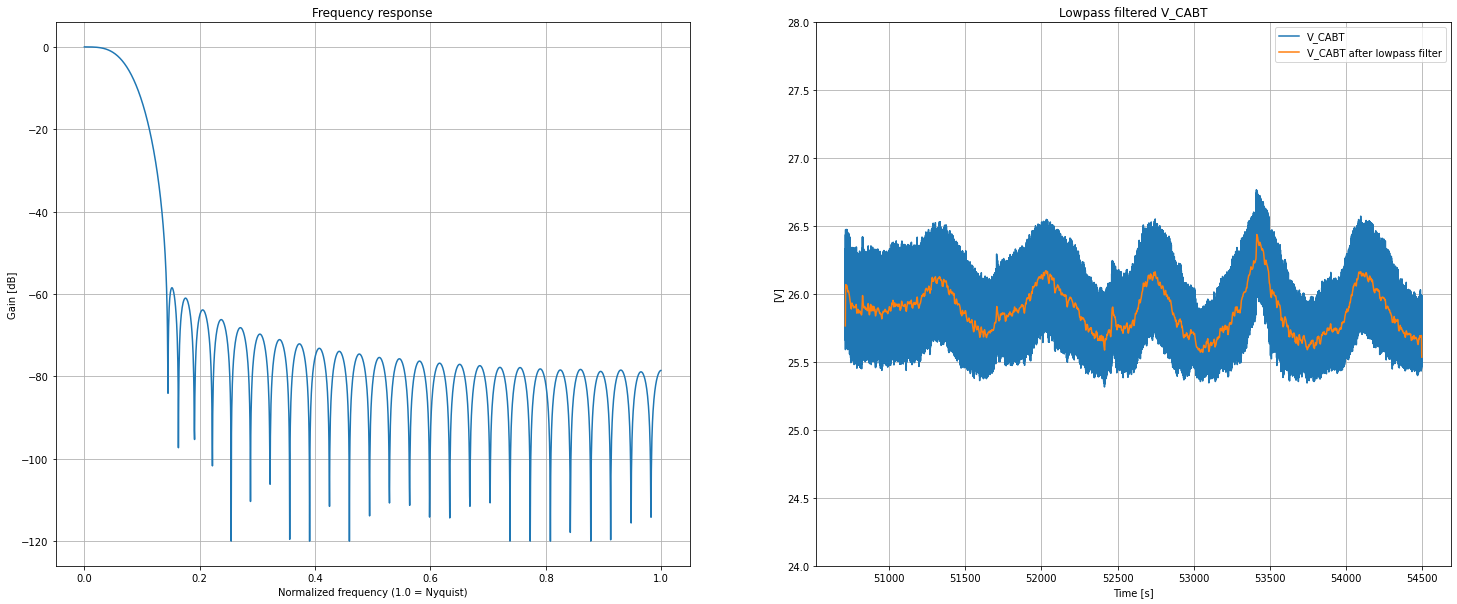

In [10]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=[25,10])

w, h = signal.sosfreqz(sos, worN=2000)
db = 20*np.log10(np.maximum(np.abs(h),1e-6))

ax1.plot(w/np.pi,db)

ax1.grid()
ax1.set_xlabel('Normalized frequency (1.0 = Nyquist)')
ax1.set_ylabel('Gain [dB]')
ax1.set_title('Frequency response')

ax2.plot(df['V_CABT'].loc[df.LINE==1003.02],label='V_CABT')
ax2.plot(df_100302['V_CABT'],label='V_CABT after lowpass filter')

ax2.grid()
ax2.legend()
ax2.set_ylim([24,28])
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('[V]')
ax2.set_title('Lowpass filtered V_CABT')
plt.show()

## 1.2 - Movemean

In [11]:
df_100302

,FLUXB_TOT,FLUXB_X,FLUXC_TOT,FLUXC_Y,FLUXD_Y,FLUXD_Z,TL_comp_mag3_sq,UNCOMPMAG3,TL_comp_mag4_sq,TL_comp_mag5_sq,V_CABT,IGRFMAG1
Time [s],,,,,,,,,,,,
50713.0,52812.377887,45838.824381,57312.194412,-20374.030120,-17986.111440,16381.698029,-941.209664,53526.628684,-1904.899320,79.190021,25.765291,-87.226
50713.1,52812.209715,45820.234772,57310.523152,-20377.377628,-17990.577489,16345.361373,-938.797342,53524.443828,-1903.332447,79.387825,25.783319,-86.141
50713.2,52812.041407,45801.657678,57308.850509,-20380.582877,-17994.901554,16309.022223,-935.928254,53522.265896,-1901.457016,80.575036,25.801266,-85.007
50713.3,52811.872828,45783.105217,57307.175082,-20383.505365,-17998.943421,16272.677679,-933.146768,53520.101715,-1899.578546,81.798915,25.819054,-83.824
50713.4,52811.703849,45764.588734,57305.495444,-20386.008083,-18002.566390,16236.324058,-930.723734,53517.957917,-1898.021817,83.025640,25.836604,-82.591
...,...,...,...,...,...,...,...,...,...,...,...,...
54496.6,51265.495920,27846.463412,54937.374140,12182.022554,13992.842644,-4643.050357,-1542.686492,51685.356262,-2606.486269,-336.052272,25.573827,-438.465
54496.7,51263.756760,27825.088167,54933.639176,12171.475786,13981.234917,-4672.193079,-1543.269818,51682.298063,-2607.646401,-337.046554,25.564349,-439.180
54496.8,51261.979771,27802.843644,54929.794384,12160.926812,13969.590478,-4702.407181,-1544.368424,51679.159910,-2609.735169,-338.136374,25.554736,-439.882


In [12]:
df_100302 = df_100302.rolling(10).mean()
df_100308 = df_100308.rolling(10).mean()
df_100304 = df_100304.rolling(10).mean()

In [13]:
df_100302

,FLUXB_TOT,FLUXB_X,FLUXC_TOT,FLUXC_Y,FLUXD_Y,FLUXD_Z,TL_comp_mag3_sq,UNCOMPMAG3,TL_comp_mag4_sq,TL_comp_mag5_sq,V_CABT,IGRFMAG1
Time [s],,,,,,,,,,,,
50713.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50713.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50713.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50713.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50713.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
54496.6,51272.170364,27916.132066,54950.835241,12229.756019,14044.301478,-4544.437343,-1542.368336,51696.684462,-2605.708754,-332.001276,25.612284,-435.1603
54496.7,51270.771441,27902.595623,54948.088947,12219.096040,14032.890228,-4563.979995,-1542.807775,51694.345099,-2606.271504,-332.906759,25.604049,-435.8941
54496.8,51269.291123,27887.181974,54945.106064,12208.476856,14021.445762,-4585.815331,-1543.210947,51691.833808,-2606.897064,-333.842069,25.595516,-436.6239


## 1.2 - Standardization

<font size="5">
$z = \frac{x-\mu}{\sigma}$
</font>

Transformation to a standard normal distribution

In [14]:
df_100302.describe()

,FLUXB_TOT,FLUXB_X,FLUXC_TOT,FLUXC_Y,FLUXD_Y,FLUXD_Z,TL_comp_mag3_sq,UNCOMPMAG3,TL_comp_mag4_sq,TL_comp_mag5_sq,V_CABT,IGRFMAG1
count,37832.000000,37832.000000,37832.000000,37832.000000,37832.000000,37832.000000,37832.000000,37832.000000,37832.000000,37832.000000,37832.000000,37832.000000
mean,52055.117520,34656.457591,55904.686119,-4206.594163,-2212.853477,2812.746553,-1056.671935,52539.602557,-2096.597445,28.163661,25.879162,-104.638736
std,670.522456,9437.875139,1252.740879,15371.841533,15254.409753,12417.329074,395.851454,1053.143080,400.095613,329.340069,0.166471,325.655980
min,50786.392173,9464.417649,52692.018061,-24977.842259,-23465.944818,-25209.295268,-1834.094553,50773.422962,-2762.600177,-539.150745,25.571127,-680.142600
25%,51419.259883,24600.171187,54718.535893,-21967.537049,-19881.106418,-9621.174475,-1354.825631,51736.194663,-2402.661361,-246.003483,25.736487,-361.655800
50%,52050.729994,38110.737711,55977.328984,5156.757567,7129.073642,5048.160904,-1086.912220,52342.556825,-2116.571287,-0.481983,25.873692,-132.717400
75%,52546.537893,41490.020541,56807.776923,8909.736422,10667.070403,10449.472085,-838.337219,52938.147944,-1842.131739,223.525505,25.997644,74.976125
max,54531.944495,53931.412566,59404.401470,17303.225425,19612.790593,41094.270721,967.617781,56436.901562,-15.163960,1751.231365,26.437199,1592.030900


In [15]:
def apply_standardization(df):
    
    scaler = StandardScaler()
    scaler.fit(df)
    df[df.columns] = scaler.transform(df[df.columns])
    
    y_mean = scaler.mean_[-1]
    y_std = np.sqrt((scaler.var_[-1]))
    
    return y_mean,y_std

In [16]:
def apply_standardization2(df):
    
    df['TL_comp_mag3_sq'] = (df['TL_comp_mag3_sq'] - (-1.056177e3))/395.6648
    df['TL_comp_mag4_sq'] = (df['TL_comp_mag4_sq'] - (-2.096303e3))/399.3658
    df['TL_comp_mag5_sq'] = (df['TL_comp_mag5_sq'] - (28.5366))    /329.4788
    df['FLUXC_TOT']       = (df['FLUXC_TOT']       - (5.589856e3)) /1.254105e3
    df['UNCOMPMAG3']      = (df['UNCOMPMAG3']      - (5.253492e3)) /1.055044e3 
    df['FLUXD_Z']         = (df['FLUXD_Z']         - (2.782271e3)) /1.2455897e4
    df['V_CABT']          = (df['V_CABT']          - (25.8781))    /0.1664
    df['FLUXB_X']         = (df['FLUXB_X']         - (3.4633559e4))/9.451651e3
    df['FLUXD_Y']         = (df['FLUXD_Y']         - (-2.228188e3))/1.5247942e4
    df['FLUXC_Y']         = (df['FLUXC_Y']         - (-4.220738e3))/1.5363530e4
    df['FLUXB_TOT']       = (df['FLUXB_TOT']       - (5.2051607e4))/668.90396

In [17]:
# y100302_mean, y100302_std = apply_standardization(df_100302)
# y100308_mean, y100308_std = apply_standardization(df_100308)
# y100304_mean, y100304_std = apply_standardization(df_100304)

In [18]:
apply_standardization2(df_100302)
apply_standardization2(df_100308)
apply_standardization2(df_100304)

In [19]:
df_100302.describe()

,FLUXB_TOT,FLUXB_X,FLUXC_TOT,FLUXC_Y,FLUXD_Y,FLUXD_Z,TL_comp_mag3_sq,UNCOMPMAG3,TL_comp_mag4_sq,TL_comp_mag5_sq,V_CABT,IGRFMAG1
count,37832.000000,37832.000000,37832.000000,37832.000000,37832.000000,37832.000000,37832.000000,37832.000000,37832.000000,37832.000000,37832.000000,37832.000000
mean,0.005248,0.002423,40.120110,0.000921,0.001006,0.002447,-0.001251,44.819089,-0.000737,-0.001132,0.006384,-104.638736
std,1.002420,0.998542,0.998912,1.000541,1.000424,0.996904,1.000472,0.998198,1.001827,0.999579,1.000425,325.655980
min,-1.891475,-2.662936,37.558388,-1.351063,-1.392828,-2.247254,-1.966103,43.145055,-1.668388,-1.722986,-1.844791,-680.142600
25%,-0.945348,-1.061549,39.174296,-1.155125,-1.157725,-0.995789,-0.754802,44.057596,-0.767112,-0.833256,-0.851039,-361.655800
50%,-0.001311,0.367891,40.178034,0.610374,0.613674,0.181913,-0.077680,44.632323,-0.050751,-0.088074,-0.026489,-132.717400
75%,0.739913,0.725425,40.840217,0.854652,0.845705,0.615548,0.550566,45.196841,0.636437,0.591810,0.718412,74.976125
max,3.708062,2.041744,42.910718,1.400978,1.432389,3.075812,5.114922,48.513057,5.211110,5.228545,3.359969,1592.030900


## 1.3 - Time Frame

Input : $[t_{-2}, t_{-1}, t_{0}, t_{+1}, t_{+2}]$

Model generate an output for $t_{0}$

In [20]:
def create_Xy(df):
    
    t_0 = df.index[2]
    t_end = df.index[-3]
    
    y = df[['IGRFMAG1']].copy()
    df = df.drop(columns='IGRFMAG1')
    y = y.drop(index=[y.index[0],y.index[1],y.index[-2],y.index[-1]])
    
    idx = df.drop(index=[df.index[0],df.index[1],df.index[-1],df.index[-2]]).index
    
    X = pd.concat([df.drop(index=[df.index[-1],df.index[-2],df.index[-3],df.index[-4]]).set_index(idx),
                   df.drop(index=[df.index[0],df.index[-1],df.index[-2],df.index[-3]]).set_index(idx),
                   df.drop(index=[df.index[0],df.index[1],df.index[-1],df.index[-2]]),
                   df.drop(index=[df.index[0],df.index[1],df.index[2],df.index[-1]]).set_index(idx),
                   df.drop(index=[df.index[0],df.index[1],df.index[2],df.index[3]]).set_index(idx)
               ],axis=1)
    
    return X,y

In [21]:
X100302, y100302 = create_Xy(df_100302)
X100308, y100308 = create_Xy(df_100308)
X100304, y100304 = create_Xy(df_100304)

Each 11 columns is shifted of 0.1s to get the new time frame with the start index time shifted of 0.2s and index end time shifted of -0.2s.

## 1.4 - Train and Validation set

Train = 4/5, Validation = 1/5

In [22]:
batch = 64

In [23]:
device = magnav.get_device()
#device = 'cpu'

Currently using cuda


In [24]:
def df_to_torch(X):
    X = torch.from_numpy(X.to_numpy()).float().to(device)
    return X

In [40]:
print('Before',type(X100302))
X100302 = df_to_torch(X100302)
print('After',type(X100302))

y100302 = df_to_torch(y100302)

X100308 = df_to_torch(X100308)
y100308 = df_to_torch(y100308)

X100304 = df_to_torch(X100304)
y100304 = df_to_torch(y100304)

Before <class 'torch.Tensor'>


AttributeError: 'Tensor' object has no attribute 'to_numpy'

In [43]:
X100302_train, X100302_val, y100302_train, y100302_val = train_test_split(X100302,y100302,test_size=1/5,shuffle=False)
X100308_train, X100308_val, y100308_train, y100308_val = train_test_split(X100308,y100308,test_size=1/5,shuffle=False)

In [47]:
train100302_dataset = torch.utils.data.TensorDataset(X100302_train,y100302_train)
train100302_loader  = torch.utils.data.DataLoader(dataset=train100302_dataset,batch_size=batch,shuffle=False)

val100302_dataset   = torch.utils.data.TensorDataset(X100302_val,y100302_val)
val100302_loader    = torch.utils.data.DataLoader(dataset=val100302_dataset,batch_size=batch,shuffle=False)

train100308_dataset = torch.utils.data.TensorDataset(X100308_train,y100308_train)
train100308_loader  = torch.utils.data.DataLoader(dataset=train100308_dataset,batch_size=batch,shuffle=False)

val100308_dataset   = torch.utils.data.TensorDataset(X100308_val,y100308_val)
val100308_loader    = torch.utils.data.DataLoader(dataset=val100308_dataset,batch_size=batch,shuffle=False)

AssertionError: Size mismatch between tensors

## 1.5 - Test concat dataset

In [28]:
Xconcat_train = torch.cat((X100302_train,X100308_train),0)
yconcat_train = torch.cat((y100302_train,y100308_train),0)

Xconcat_val = torch.cat((X100302_val,X100308_val),0)
yconcat_val = torch.cat((y100302_val,y100308_val),0)

In [29]:
trainconcat_dataset = torch.utils.data.TensorDataset(Xconcat_train,yconcat_train)
trainconcat_loader  = torch.utils.data.DataLoader(dataset=trainconcat_dataset,batch_size=batch,shuffle=False)

valconcat_dataset = torch.utils.data.TensorDataset(Xconcat_val,yconcat_val)
valconcat_loader  = torch.utils.data.DataLoader(dataset=valconcat_dataset,batch_size=batch,shuffle=False)

In [30]:
Xconcat_train

tensor([[    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        ...,
        [ 0.4558, -1.2665, 39.2527,  ...,  1.0131,  0.9460,  0.6269],
        [ 0.4617, -1.2510, 39.2655,  ...,  1.0180,  0.9482,  0.6343],
        [ 0.4675, -1.2356, 39.2783,  ...,  1.0230,  0.9505,  0.6417]],
       device='cuda:0')

# 2 - MLP

In [31]:
def count_parameters(model):
    
    total_params = 0
    table = np.array([["Modules","Parameters"]])

    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table = np.concatenate((table,[[name,params]]),axis=0)
        total_params += params
    table = np.concatenate((table,[["",""],["Total Trainable Params",total_params]]),axis=0)
    print(tabulate(table,headers='firstrow',tablefmt="pipe",stralign='right'))

## 2.1 - Imported model

In [32]:
weights_0 = np.genfromtxt('../models/Challenge_model/weights_in.csv',delimiter=',')
weights_1 = np.genfromtxt('../models/Challenge_model/weights_hidden1.csv',delimiter=',')
weights_2 = np.genfromtxt('../models/Challenge_model/weights_hidden2.csv',delimiter=',')
weights_3 = np.reshape(np.genfromtxt('../models/Challenge_model/weights_hidden3.csv',delimiter=','),[-1,1]).T

biases_0  = np.genfromtxt('../models/Challenge_model/biases_hidden1.csv',delimiter=',')
biases_1  = np.genfromtxt('../models/Challenge_model/biases_hidden2.csv',delimiter=',')
biases_2  = np.genfromtxt('../models/Challenge_model/biases_hidden3.csv',delimiter=',')
biases_3  = np.reshape(np.genfromtxt('../models/Challenge_model/biases_out.csv',delimiter=','),1)

In [33]:
print(weights_0.shape,biases_0.shape)
print(weights_1.shape,biases_1.shape)
print(weights_2.shape,biases_2.shape)
print(weights_3.shape,biases_3.shape)

(80, 55) (80,)
(40, 80) (40,)
(20, 40) (20,)
(1, 20) (1,)


In [34]:
class Chall_MLP_import(torch.nn.Module):
    
    def __init__(self):
        super(Chall_MLP_import, self).__init__()
        self.architecture = torch.nn.Sequential(
            torch.nn.Linear(55,80),
            torch.nn.Tanh(),
            torch.nn.Linear(80,40),
            torch.nn.Tanh(),
            torch.nn.Linear(40,20),
            torch.nn.Tanh(),
            torch.nn.Linear(20,1),
        )
        
    def forward(self, x):
        logits = self.architecture(x)
        return logits

In [35]:
model_import = Chall_MLP_import()
count_parameters(model_import)
for name, param in model_import.named_parameters():
    print(np.shape(param.data))

|                Modules |   Parameters |
|-----------------------:|-------------:|
|  architecture.0.weight |         4400 |
|    architecture.0.bias |           80 |
|  architecture.2.weight |         3200 |
|    architecture.2.bias |           40 |
|  architecture.4.weight |          800 |
|    architecture.4.bias |           20 |
|  architecture.6.weight |           20 |
|    architecture.6.bias |            1 |
|                        |              |
| Total Trainable Params |         8561 |
torch.Size([80, 55])
torch.Size([80])
torch.Size([40, 80])
torch.Size([40])
torch.Size([20, 40])
torch.Size([20])
torch.Size([1, 20])
torch.Size([1])


In [36]:
import_params = [weights_0,biases_0,weights_1,biases_1,weights_2,biases_2,weights_3,biases_3]
i = 0
for name, param in model_import.named_parameters():
    param.data = torch.from_numpy(import_params[i])
    i += 1

In [37]:
for name, param in model_import.named_parameters():
    print(np.shape(param.data))

torch.Size([80, 55])
torch.Size([80])
torch.Size([40, 80])
torch.Size([40])
torch.Size([20, 40])
torch.Size([20])
torch.Size([1, 20])
torch.Size([1])


1003.02 | 252.29155
1003.08 | 109.631424
1003.04 | 323.156


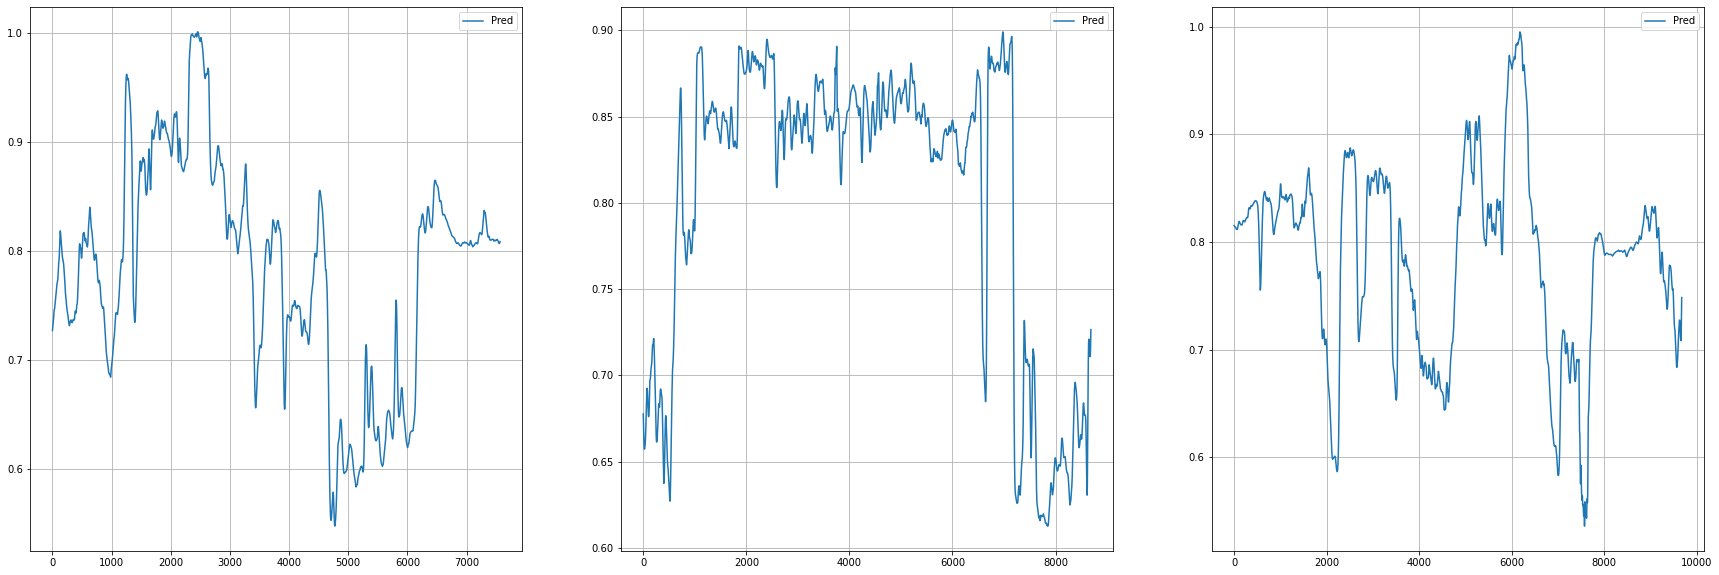

In [52]:
with torch.no_grad():

    model_import.float()
    model_import.to(device)

    pred = model_import(X100302_val)

    pred = (pred.cpu().detach().numpy())
    true = (y100302_val.cpu().detach().numpy())

    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[30,10],sharey=False)
    ax1.plot(pred,label='Pred')
    #ax1.plot(true,label='True')
    ax1.legend()
    ax1.grid()
    print('1003.02 |',magnav.rmse(pred,true))

    pred = model_import(X100308_val)

    pred = pred.cpu().detach().numpy()
    true = y100308_val.cpu().detach().numpy()

    ax2.plot(pred,label='Pred')
#     ax2.plot(true,label='True')
    ax2.legend()
    ax2.grid()
    print('1003.08 |',magnav.rmse(pred,true))

    pred = model_import(X100304[int((4/5)*len(X100304)):])

    pred = pred.cpu().detach().numpy()
    true = y100304[int((4/5)*len(X100304)):].cpu().detach().numpy()

    ax3.plot(pred,label='Pred')
    #ax3.plot(true,label='True')
    ax3.legend()
    ax3.grid()
    print('1003.04 |',magnav.rmse(pred,true))

## 2.2 - Model from scratch

### 2.2.1 - Architecture

In [26]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [27]:
class Chall_MLP(torch.nn.Module):
    
    def __init__(self):
        super(Chall_MLP, self).__init__()
        self.architecture = torch.nn.Sequential(
            torch.nn.Linear(55,80),
            torch.nn.Tanh(),
            torch.nn.Linear(80,40),
            torch.nn.Tanh(),
            torch.nn.Linear(40,20),
            torch.nn.Tanh(),
            torch.nn.Linear(20,1),
        )
        self.architecture.apply(init_weights)
        
        
    def forward(self, x):
        logits = self.architecture(x)
        return logits

In [77]:
model = Chall_MLP().to(device)
print(model)
count_parameters(model)

Chall_MLP(
  (architecture): Sequential(
    (0): Linear(in_features=55, out_features=80, bias=True)
    (1): Tanh()
    (2): Linear(in_features=80, out_features=40, bias=True)
    (3): Tanh()
    (4): Linear(in_features=40, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=1, bias=True)
  )
)
|                Modules |   Parameters |
|-----------------------:|-------------:|
|  architecture.0.weight |         4400 |
|    architecture.0.bias |           80 |
|  architecture.2.weight |         3200 |
|    architecture.2.bias |           40 |
|  architecture.4.weight |          800 |
|    architecture.4.bias |           20 |
|  architecture.6.weight |           20 |
|    architecture.6.bias |            1 |
|                        |              |
| Total Trainable Params |         8561 |


### 2.2.2 - Loss Function

This class ensure that during a backward pass, when you multiply 0 by $\infty$ (derivative of $\sqrt{0}$), the returned tensor will be 0 and not Nan

In [44]:
class RMSELoss(torch.nn.Module):
    
    def __init__(self):
        super(RMSELoss,self).__init__()
        
    def forward(self,yhat,y):
        criterion = torch.nn.MSELoss()
        loss = torch.sqrt(criterion(yhat,y)+1e-6)
        return loss 

In [45]:
criterion = RMSELoss()

### 2.2.3 - Optimizer

In [46]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3) 

In [47]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.9,patience=5,min_lr=1e-5)

### 2.2.4 - Training loop

In [50]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/Chall_MLP_{timestamp}')

EPOCHS = 500

pbar = tqdm_notebook(total=EPOCHS,unit="epoch",desc='Training')

for epoch in range(EPOCHS):

    train_running_loss = 0.

    # Make sure gradient tracking is on, and do a pass over the data
    model.train()

    # Enumerate allow to track batch index and intra-epoch reporting 
    for i, (inputs, labels) in enumerate(trainconcat_loader):

        # Zero gradients for every batch
        optimizer.zero_grad()

        # Make prediction for this batch
        predictions = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(predictions, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        train_running_loss += loss.detach().item() * inputs.size(0)
        

    avg_loss = train_running_loss/ len(trainconcat_loader.dataset)
    writer.add_scalar('training_loss',avg_loss,epoch)
    
    # Desactivate layers such as dropout or batch-normalization
    model.eval()

    val_running_loss = 0.0
    
    
    with torch.set_grad_enabled(False):
        for i, (vinputs, vlabels) in enumerate(valconcat_loader):

            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            val_running_loss += vloss.detach().item()* vinputs.size(0)

    avg_vloss = val_running_loss/len(valconcat_loader.dataset)
    
    scheduler.step(avg_vloss)
    
    writer.add_scalar('validation_loss',avg_vloss,epoch)
    
    pbar.set_postfix(train_loss=avg_loss,val_loss=avg_vloss,lr=optimizer.param_groups[0]['lr'])
    pbar.update()

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

In [34]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter(f'runs/Chall_MLP_{timestamp}')

EPOCHS = 500

pbar = tqdm_notebook(total=EPOCHS,unit="epoch",desc='Training')

for epoch in range(EPOCHS):

    train_running_loss = 0.

    # Make sure gradient tracking is on, and do a pass over the data
    model.train()

    # Enumerate allow to track batch index and intra-epoch reporting 
    for i, (inputs, labels) in enumerate(trainconcat_loader):

        # Zero gradients for every batch
        optimizer.zero_grad()

        # Make prediction for this batch
        predictions = model(inputs)

        # Compute the loss and its gradients
        loss = criterion(predictions, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        train_running_loss += loss.detach().item() * inputs.size(0)
        

    avg_loss = train_running_loss/ len(trainconcat_loader.dataset)
    writer.add_scalar('training_loss',avg_loss,epoch)
    
    # Desactivate layers such as dropout or batch-normalization
    model.eval()

    val_running_loss = 0.0
    
    
    with torch.set_grad_enabled(False):
        for i, (vinputs, vlabels) in enumerate(valconcat_loader):

            voutputs = model(vinputs)
            vloss = criterion(voutputs, vlabels)
            val_running_loss += vloss.detach().item()* vinputs.size(0)

    avg_vloss = val_running_loss/len(valconcat_loader.dataset)
    
    scheduler.step(avg_vloss)
    
    writer.add_scalar('validation_loss',avg_vloss,epoch)
    
    pbar.set_postfix(train_loss=avg_loss,val_loss=avg_vloss,lr=optimizer.param_groups[0]['lr'])
    pbar.update()

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

# 3 - Predictions

1003.02 | 13.940511
1003.08 | 15.50003
1003.04 | 32.20709


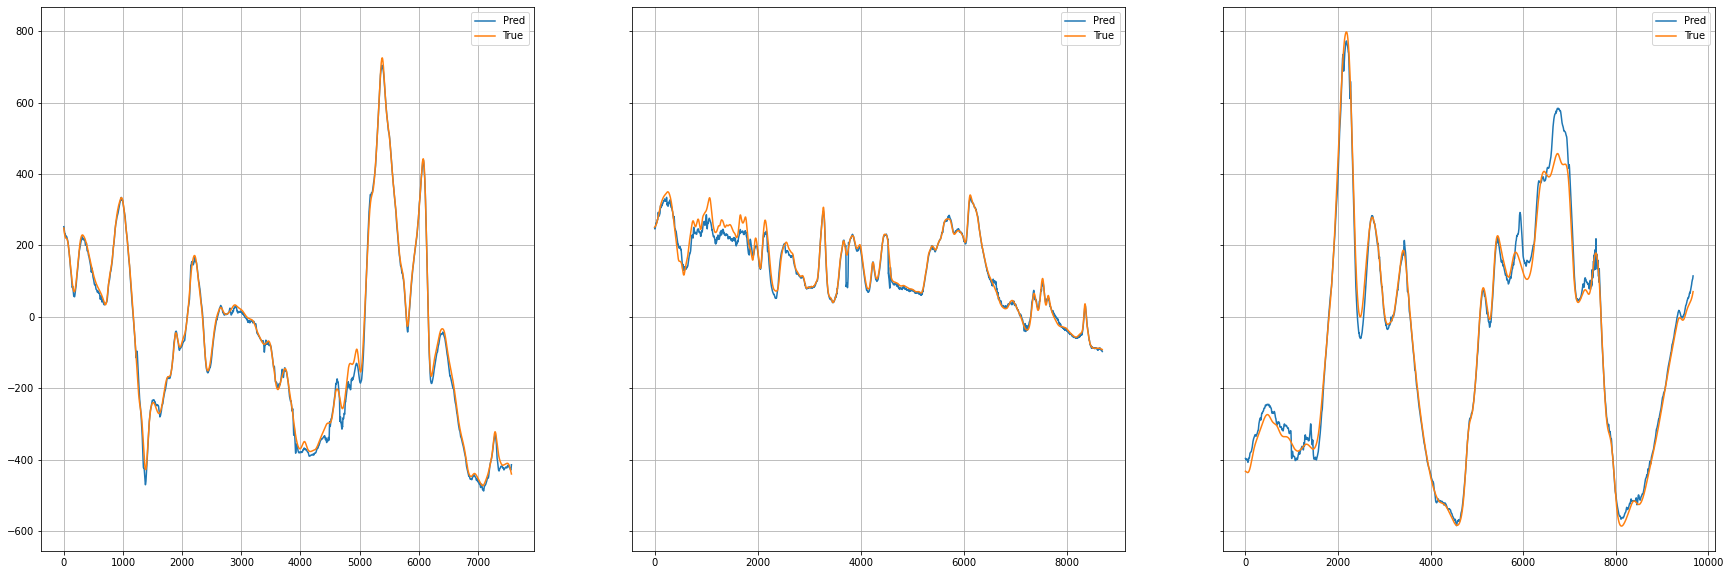

In [52]:
with torch.no_grad():
    
    pred = model(X100302_val)
    
    pred = (pred.cpu().detach().numpy()*y100302_std)+y100302_mean
    true = (y100302_val.cpu().detach().numpy()*y100302_std)+y100302_mean
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[30,10],sharey=True)
    ax1.plot(pred,label='Pred')
    ax1.plot(true,label='True')
    ax1.legend()
    ax1.grid()
    print('1003.02 |',magnav.rmse(pred,true))
    
    pred = model(X100308_val)

    pred = (pred.cpu().detach().numpy()*y100308_std)+y100308_mean
    true = (y100308_val.cpu().detach().numpy()*y100308_std)+y100308_mean
    
    ax2.plot(pred,label='Pred')
    ax2.plot(true,label='True')
    ax2.legend()
    ax2.grid()
    print('1003.08 |',magnav.rmse(pred,true))
    
    pred = model(X100304[int((4/5)*len(X100304)):])
    
    pred = (pred.cpu().detach().numpy()*y100304_std)+y100304_mean
    true = (y100304[int((4/5)*len(X100304)):].cpu().detach().numpy()*y100304_std)+y100304_mean
    
    ax3.plot(pred,label='Pred')
    ax3.plot(true,label='True')
    ax3.legend()
    ax3.grid()
    print('1003.04 |',magnav.rmse(pred,true))
    
    

In [1]:
#TODO gif of fitting evolution

# 4- Multiple MLP

In [36]:
def train_model(model_MLP):  
    
    criterion = RMSELoss()
    optimizer = torch.optim.Adam(model_MLP.parameters(),lr=1e-3) 
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.9,patience=5,min_lr=1e-5)
    
    EPOCHS = 500

    pbar = tqdm_notebook(total=EPOCHS,unit="epoch",desc='Training')

    for epoch in range(EPOCHS):

        train_running_loss = 0.

        # Make sure gradient tracking is on, and do a pass over the data
        model_MLP.train()

        # Enumerate allow to track batch index and intra-epoch reporting 
        for i, (inputs, labels) in enumerate(trainconcat_loader):

            # Zero gradients for every batch
            optimizer.zero_grad()

            # Make prediction for this batch
            predictions = model_MLP(inputs)

            # Compute the loss and its gradients
            loss = criterion(predictions, labels)
            loss.backward()

            # Adjust learning weights
            optimizer.step()

            # Gather data and report
            train_running_loss += loss.detach().item() * inputs.size(0)


        avg_loss = train_running_loss/ len(trainconcat_loader.dataset)
        writer.add_scalar('training_loss',avg_loss,epoch)

        # Desactivate layers such as dropout or batch-normalization
        model_MLP.eval()

        val_running_loss = 0.0


        with torch.set_grad_enabled(False):
            for i, (vinputs, vlabels) in enumerate(valconcat_loader):

                voutputs = model_MLP(vinputs)
                vloss = criterion(voutputs, vlabels)
                val_running_loss += vloss.detach().item()* vinputs.size(0)

        avg_vloss = val_running_loss/len(valconcat_loader.dataset)

        scheduler.step(avg_vloss)

        writer.add_scalar('validation_loss',avg_vloss,epoch)

        pbar.set_postfix(train_loss=avg_loss,val_loss=avg_vloss,lr=optimizer.param_groups[0]['lr'])
        pbar.update()

In [37]:
model2 = Chall_MLP().to(device)
model3 = Chall_MLP().to(device)
model4 = Chall_MLP().to(device)
model5 = Chall_MLP().to(device)
model6 = Chall_MLP().to(device)
model7 = Chall_MLP().to(device)
model8 = Chall_MLP().to(device)
model9 = Chall_MLP().to(device)
model10 = Chall_MLP().to(device)
model11 = Chall_MLP().to(device)
model12 = Chall_MLP().to(device)

train_model(model2)
train_model(model3)
train_model(model4)
train_model(model5)
train_model(model6)
train_model(model7)
train_model(model8)
train_model(model9)
train_model(model10)
train_model(model11)
train_model(model12)

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

1003.02 | 45.4377
1003.08 | 17.884035
1003.04 | 40.01184


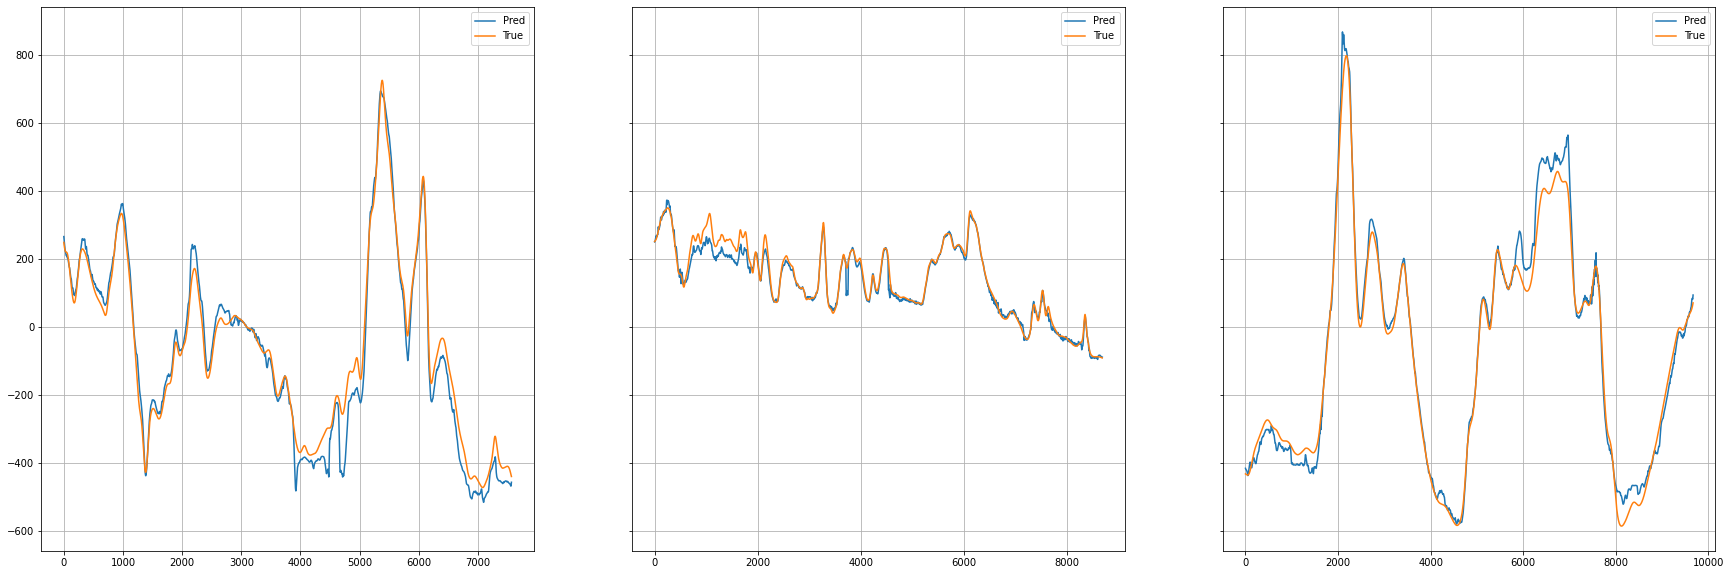

In [40]:
with torch.no_grad():
    
    pred1 = model(X100302_val)
    pred2 = model2(X100302_val)
    pred3 = model3(X100302_val)
    pred4 = model4(X100302_val)
    pred5 = model5(X100302_val)
    pred6 = model6(X100302_val)
    pred7 = model8(X100302_val)
    pred8 = model8(X100302_val)
    pred9 = model9(X100302_val)
    pred10 = model10(X100302_val)
    pred11 = model11(X100302_val)
    pred12 = model12(X100302_val)
    
    pred = (pred1+pred2+pred3+pred4+pred5+pred6+pred7+pred8+pred9+pred10+pred11+pred12)/12
    
    pred = (pred.cpu().detach().numpy()*y100302_std)+y100302_mean
    true = (y100302_val.cpu().detach().numpy()*y100302_std)+y100302_mean
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[30,10],sharey=True)
    ax1.plot(pred,label='Pred')
    ax1.plot(true,label='True')
    ax1.legend()
    ax1.grid()
    print('1003.02 |',magnav.rmse(pred,true))
    
    pred1 = model(X100308_val)
    pred2 = model2(X100308_val)
    pred3 = model3(X100308_val)
    pred4 = model4(X100308_val)
    pred5 = model5(X100308_val)
    pred6 = model6(X100308_val)
    pred7 = model8(X100308_val)
    pred8 = model8(X100308_val)
    pred9 = model9(X100308_val)
    pred10 = model10(X100308_val)
    pred11 = model11(X100308_val)
    pred12 = model12(X100308_val)
    
    pred = (pred1+pred2+pred3+pred4+pred5+pred6+pred7+pred8+pred9+pred10+pred11+pred12)/12

    pred = (pred.cpu().detach().numpy()*y100308_std)+y100308_mean
    true = (y100308_val.cpu().detach().numpy()*y100308_std)+y100308_mean
    
    ax2.plot(pred,label='Pred')
    ax2.plot(true,label='True')
    ax2.legend()
    ax2.grid()
    print('1003.08 |',magnav.rmse(pred,true))
    
    pred1 = model(X100304[int((4/5)*len(X100304)):])
    pred2 = model2(X100304[int((4/5)*len(X100304)):])
    pred3 = model3(X100304[int((4/5)*len(X100304)):])
    pred4 = model4(X100304[int((4/5)*len(X100304)):])
    pred5 = model5(X100304[int((4/5)*len(X100304)):])
    pred6 = model6(X100304[int((4/5)*len(X100304)):])
    pred7 = model8(X100304[int((4/5)*len(X100304)):])
    pred8 = model8(X100304[int((4/5)*len(X100304)):])
    pred9 = model9(X100304[int((4/5)*len(X100304)):])
    pred10 = model10(X100304[int((4/5)*len(X100304)):])
    pred11 = model11(X100304[int((4/5)*len(X100304)):])
    pred12 = model12(X100304[int((4/5)*len(X100304)):])
    
    pred = (pred1+pred2+pred3+pred4+pred5+pred6+pred7+pred8+pred9+pred10+pred11+pred12)/12
    
    pred = (pred.cpu().detach().numpy()*y100304_std)+y100304_mean
    true = (y100304[int((4/5)*len(X100304)):].cpu().detach().numpy()*y100304_std)+y100304_mean
    
    ax3.plot(pred,label='Pred')
    ax3.plot(true,label='True')
    ax3.legend()
    ax3.grid()
    print('1003.04 |',magnav.rmse(pred,true))

In [ ]:
# def create_timeframe(X,y):
    
#     y = y.drop(index=[y.index[0],y.index[1],y.index[-2],y.index[-1]])

#     idx = X.drop(index=[X.index[0],X.index[1],X.index[-1],X.index[-2]]).index
    
#     X = pd.concat([X.drop(index=[X.index[-1],X.index[-2],X.index[-3],X.index[-4]]).set_index(idx),
#                    X.drop(index=[X.index[0],X.index[-1],X.index[-2],X.index[-3]]).set_index(idx),
#                    X.drop(index=[X.index[0],X.index[1],X.index[-1],X.index[-2]]),
#                    X.drop(index=[X.index[0],X.index[1],X.index[2],X.index[-1]]).set_index(idx),
#                    X.drop(index=[X.index[0],X.index[1],X.index[2],X.index[3]]).set_index(idx)
#                ],axis=1)
    
#     return X,y